In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/My Drive/prosperLoanData.csv'
import pandas as pd
df = pd.read_csv(file_path)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import ADASYN
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# List of relevant columns
relevant_columns = [
    'Term', 'LoanStatus', 'BorrowerAPR', 'BorrowerRate', 'LenderYield',
    'EstimatedEffectiveYield', 'EstimatedLoss', 'EstimatedReturn',
    'ProsperRating (numeric)', 'ProsperRating (Alpha)', 'ProsperScore',
    'ListingCategory (numeric)', 'BorrowerState', 'Occupation',
    'EmploymentStatus', 'EmploymentStatusDuration', 'IsBorrowerHomeowner',
    'CreditScoreRangeLower', 'CreditScoreRangeUpper', 'CurrentCreditLines',
    'OpenCreditLines', 'TotalCreditLinespast7years',
    'OpenRevolvingAccounts', 'OpenRevolvingMonthlyPayment',
    'InquiriesLast6Months', 'CurrentDelinquencies', 'AmountDelinquent',
    'PublicRecordsLast10Years', 'RevolvingCreditBalance',
    'BankcardUtilization', 'DebtToIncomeRatio', 'IncomeRange',
    'IncomeVerifiable', 'StatedMonthlyIncome', 'LoanOriginalAmount',
    'LoanMonthsSinceOrigination', 'MonthlyLoanPayment',
]
df = df[relevant_columns]



In [ ]:
# List of relevant columns after PCA Multicolinearity Test
filtered_columns = [
    'Term', 'LoanStatus', 'BorrowerAPR', 'EstimatedReturn',
    'ProsperRating (numeric)', 'ListingCategory (numeric)',
    'BorrowerState', 'Occupation', 'EmploymentStatus',
    'IsBorrowerHomeowner', 'CreditScoreRangeLower',
    'OpenCreditLines', 'TotalCreditLinespast7years',
    'OpenRevolvingAccounts', 'OpenRevolvingMonthlyPayment',
    'InquiriesLast6Months', 'CurrentDelinquencies',
    'AmountDelinquent', 'PublicRecordsLast10Years',
    'RevolvingCreditBalance', 'BankcardUtilization',
    'DebtToIncomeRatio', 'IncomeRange', 'IncomeVerifiable',
    'StatedMonthlyIncome', 'LoanOriginalAmount',
    'MonthlyLoanPayment'
]



# Slice out the relevant columns
sliced_data = df[filtered_columns]

# Calculate the percentage of missing values for each column
missing_percentage = sliced_data.isnull().mean() * 100

# Drop columns with more than 50% missing values, if they exist in the DataFrame
columns_to_drop = missing_percentage[missing_percentage > 50].index.intersection(sliced_data.columns)
sliced_data = sliced_data.drop(columns=columns_to_drop)

# Impute missing values
# Numerical columns
numerical_cols = sliced_data.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_cols:
    sliced_data[col].fillna(sliced_data[col].mean(), inplace=True)

# Categorical columns
categorical_cols = sliced_data.select_dtypes(include=['object', 'bool']).columns
for col in categorical_cols:
    sliced_data[col].fillna(sliced_data[col].mode()[0], inplace=True)

# Convert negative values to zero
sliced_data[numerical_cols] = sliced_data[numerical_cols].applymap(lambda x: max(x, 0))

In [ ]:
sliced_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 27 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Term                         113937 non-null  int64  
 1   LoanStatus                   113937 non-null  object 
 2   BorrowerAPR                  113937 non-null  float64
 3   EstimatedReturn              113937 non-null  float64
 4   ProsperRating (numeric)      113937 non-null  float64
 5   ListingCategory (numeric)    113937 non-null  int64  
 6   BorrowerState                113937 non-null  object 
 7   Occupation                   113937 non-null  object 
 8   EmploymentStatus             113937 non-null  object 
 9   IsBorrowerHomeowner          113937 non-null  bool   
 10  CreditScoreRangeLower        113937 non-null  float64
 11  OpenCreditLines              113937 non-null  float64
 12  TotalCreditLinespast7years   113937 non-null  float64
 13 

In [ ]:
# Mapping LoanStatus to RiskCategory
def map_loan_status(status):
    if status in ['Current', 'Completed']:
        return 'Low Risk'
    
    elif status in ['FinalPaymentInProgress', 'Past Due (1-15 days)', 
                    'Past Due (16-30 days)', 'Past Due (31-60 days)', 
                    'Past Due (61-90 days)', 'Past Due (91-120 days)']:
        return 'Medium Risk'
    
    elif status in ['Chargedoff', 'Defaulted', 
                    'Past Due (>120 days)', 'Cancelled']:
        return 'High Risk'

sliced_data['RiskCategory'] = sliced_data['LoanStatus'].apply(map_loan_status)

In [ ]:
# Encoding categorical variables using LabelEncoder
le = LabelEncoder()
for col in categorical_cols:
    sliced_data[col] = le.fit_transform(sliced_data[col])

In [ ]:
sliced_data.shape

(113937, 28)

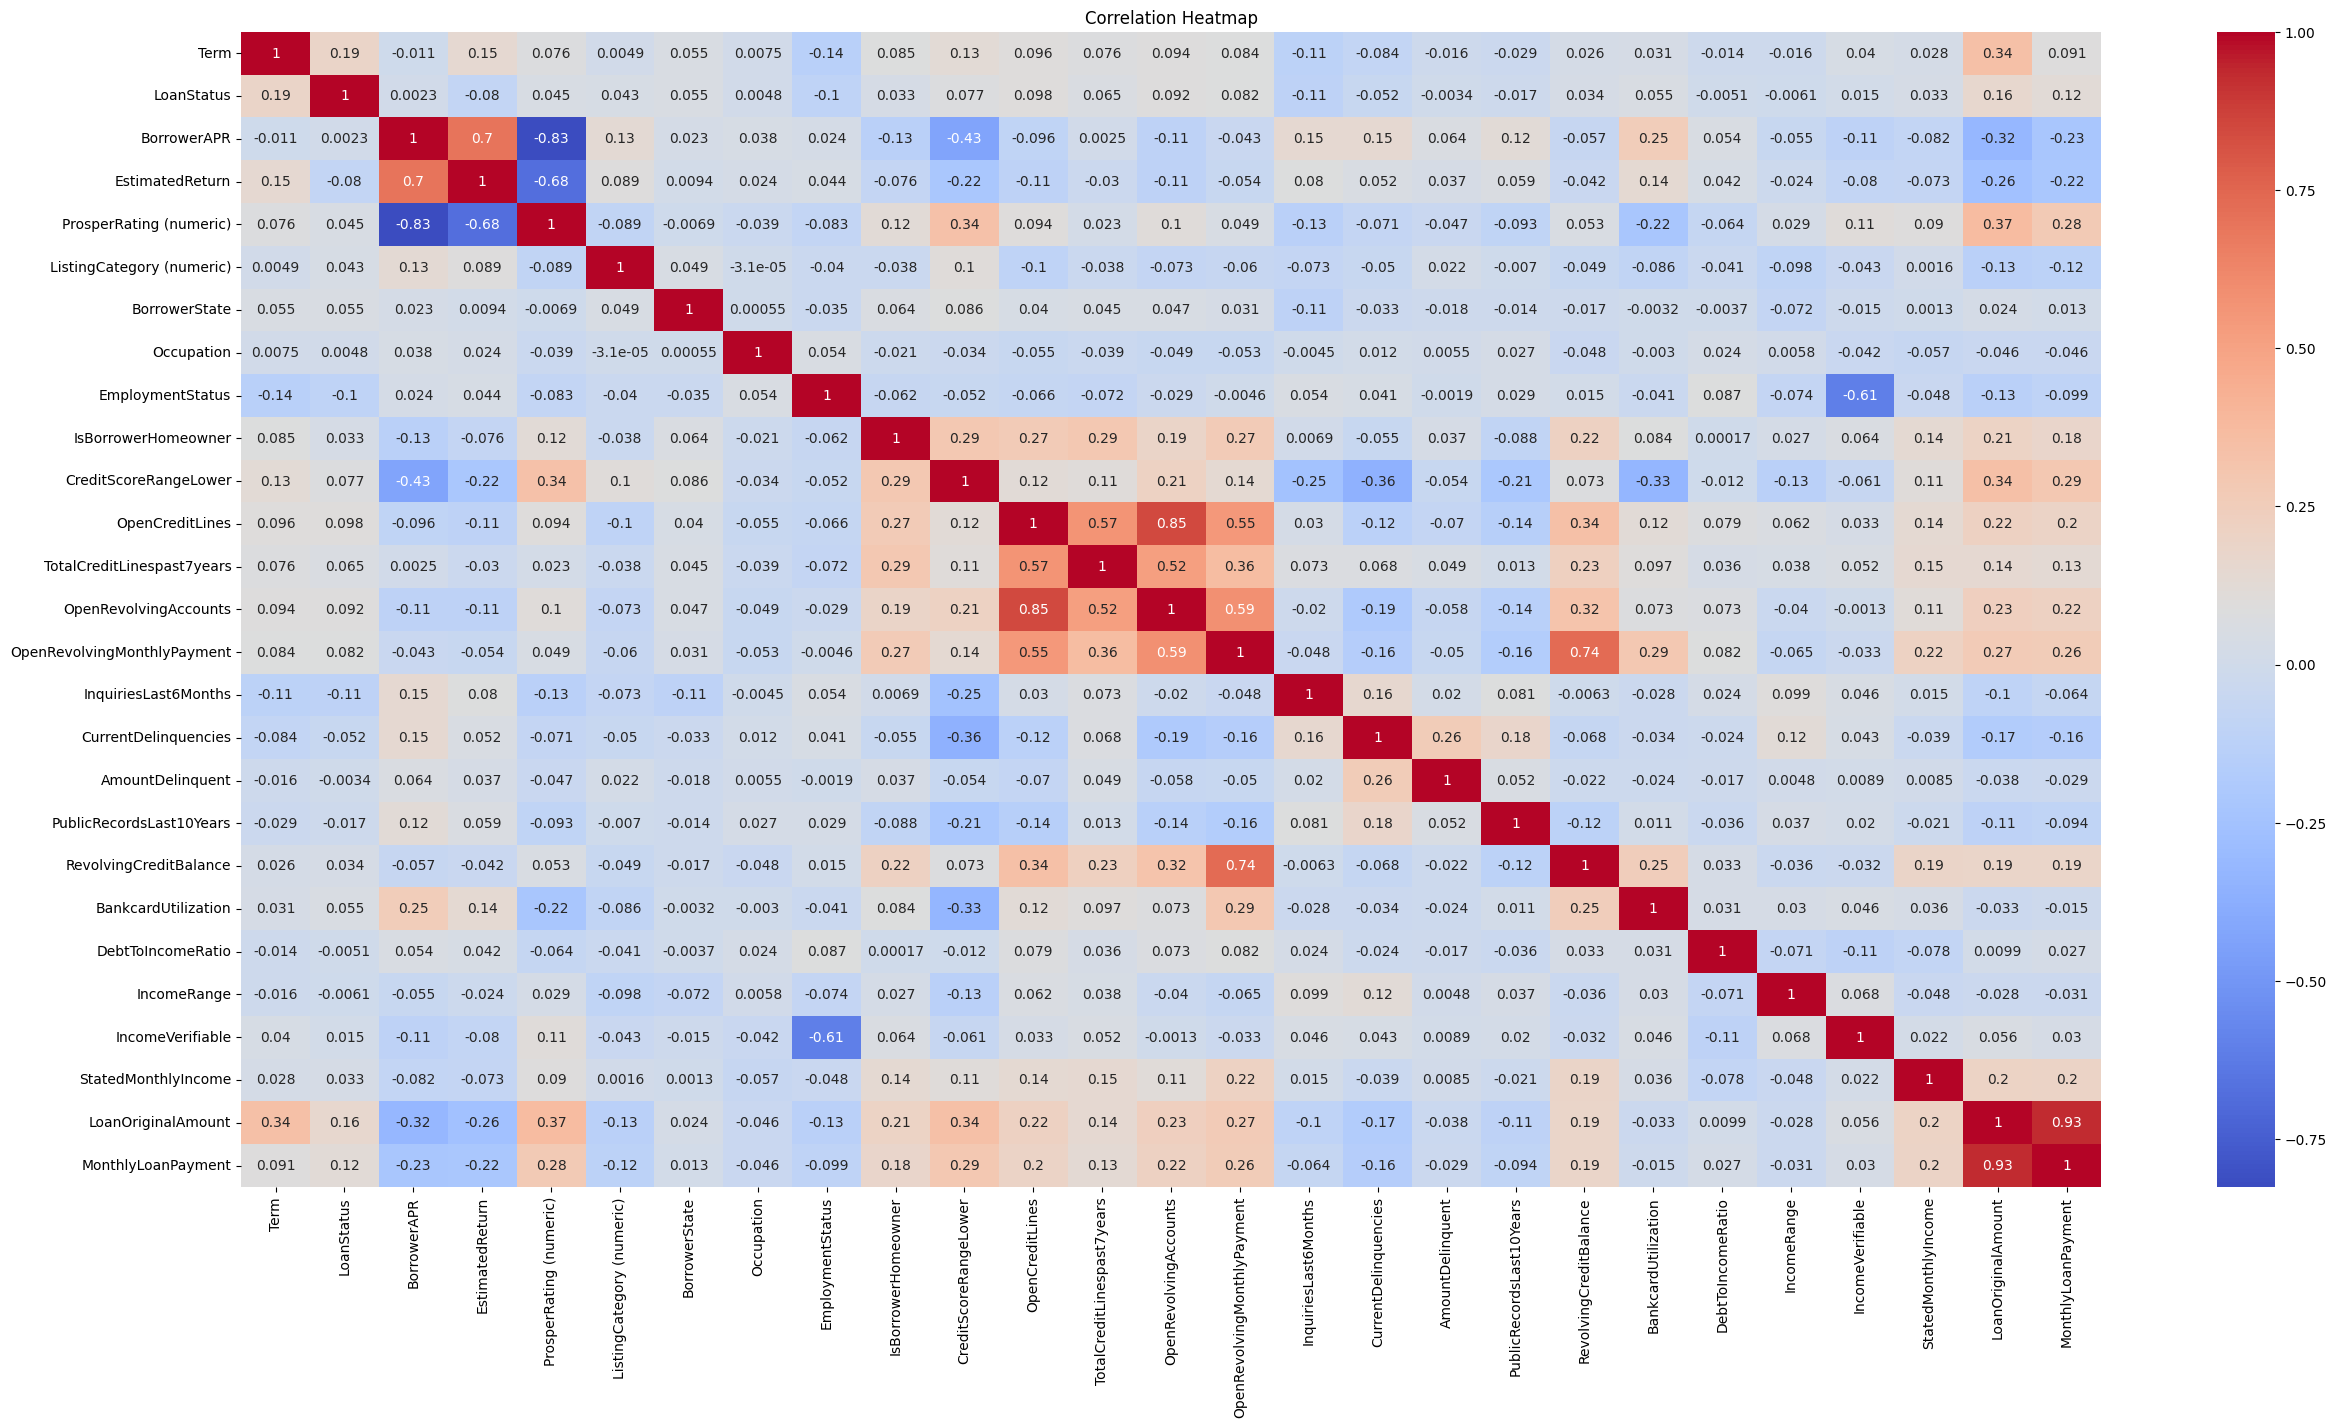

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize=(30, 15))
sns.heatmap(sliced_data.drop(columns='RiskCategory').corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# Split the data into features and target
X = sliced_data.drop('RiskCategory', axis=1)
y = sliced_data['RiskCategory']

# Encoding the target variable
y = le.fit_transform(y)

# Train and Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


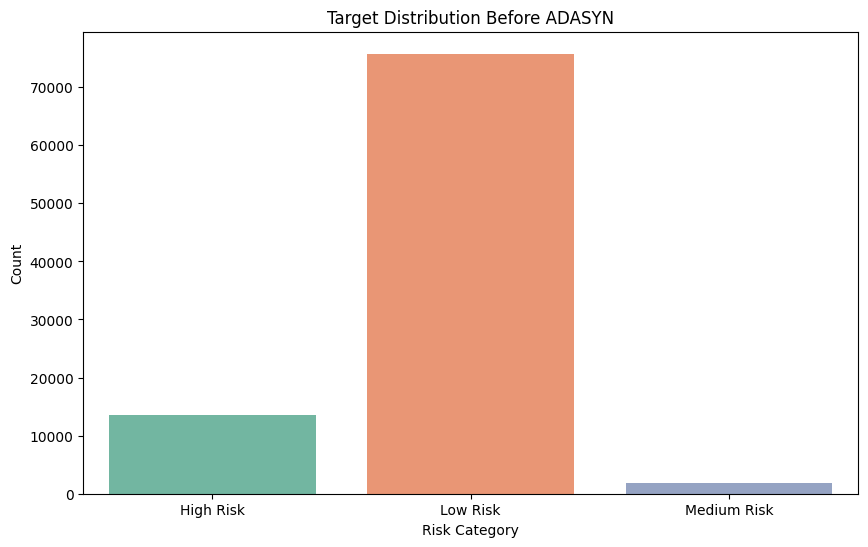

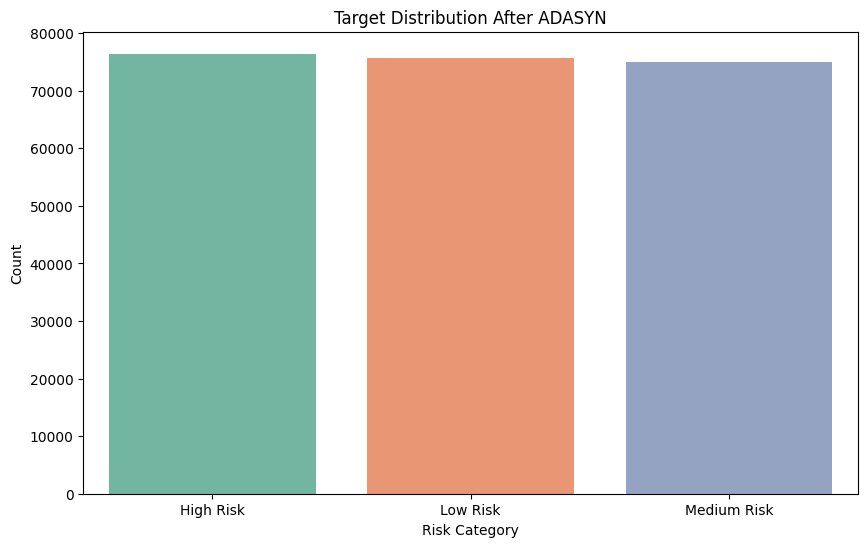

In [ ]:
# Visualizing the data distribution before ADASYN
plt.figure(figsize=(10, 6))
sns.countplot(x=y_train, palette='Set2')
plt.title('Target Distribution Before ADASYN')
plt.xlabel('Risk Category')
plt.ylabel('Count')
plt.xticks(ticks=np.arange(3), labels=le.inverse_transform([0, 1, 2]))
plt.show()

# Handling class imbalance using ADASYN
adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

# Visualizing the  data distribution after ADASYN
plt.figure(figsize=(10, 6))
sns.countplot(x=y_train_resampled, palette='Set2')
plt.title('Target Distribution After ADASYN')
plt.xlabel('Risk Category')
plt.ylabel('Count')
plt.xticks(ticks=np.arange(3), labels=le.inverse_transform([0, 1, 2]))
plt.show()

In [ ]:
# Regularized models using pipelines
rf_model = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(
        random_state=42,
        max_depth=15,           # Allow deeper trees for complexity
        min_samples_split=10,   # Slightly higher to reduce overfitting
        min_samples_leaf=5      # Ensures leaves have a reasonable number of samples
    )
)

dt_model = make_pipeline(
    StandardScaler(),
    DecisionTreeClassifier(
        random_state=42,
        max_depth=15,           # Allow deeper trees for complexity
        min_samples_split=10,   # Slightly higher to reduce overfitting
        min_samples_leaf=5      # Ensures robustness
    )
)

lr_model = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        random_state=42,
        penalty='l2',
        C=0.5                   # Slightly lower for stronger regularization
    )
)


# KFold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Train and evaluate models using KFold
models = {'RandomForest': rf_model, 'DecisionTree': dt_model, 'LogisticRegression': lr_model}
results = {}

In [ ]:
for model_name, model in models.items():
    y_pred = cross_val_predict(model, X_train_resampled, y_train_resampled, cv=kf)
    print(f"{model_name} Classification Report:")
    print(classification_report(y_train_resampled, y_pred, target_names=le.classes_))
    results[model_name] = model



RandomForest Classification Report:
              precision    recall  f1-score   support

   High Risk       1.00      0.98      0.99     76431
    Low Risk       0.98      1.00      0.99     75765
 Medium Risk       1.00      1.00      1.00     74980

    accuracy                           0.99    227176
   macro avg       0.99      0.99      0.99    227176
weighted avg       0.99      0.99      0.99    227176

DecisionTree Classification Report:
              precision    recall  f1-score   support

   High Risk       1.00      0.97      0.98     76431
    Low Risk       0.97      1.00      0.98     75765
 Medium Risk       1.00      1.00      1.00     74980

    accuracy                           0.99    227176
   macro avg       0.99      0.99      0.99    227176
weighted avg       0.99      0.99      0.99    227176

LogisticRegression Classification Report:
              precision    recall  f1-score   support

   High Risk       0.81      0.81      0.81     76431
    Low Risk   

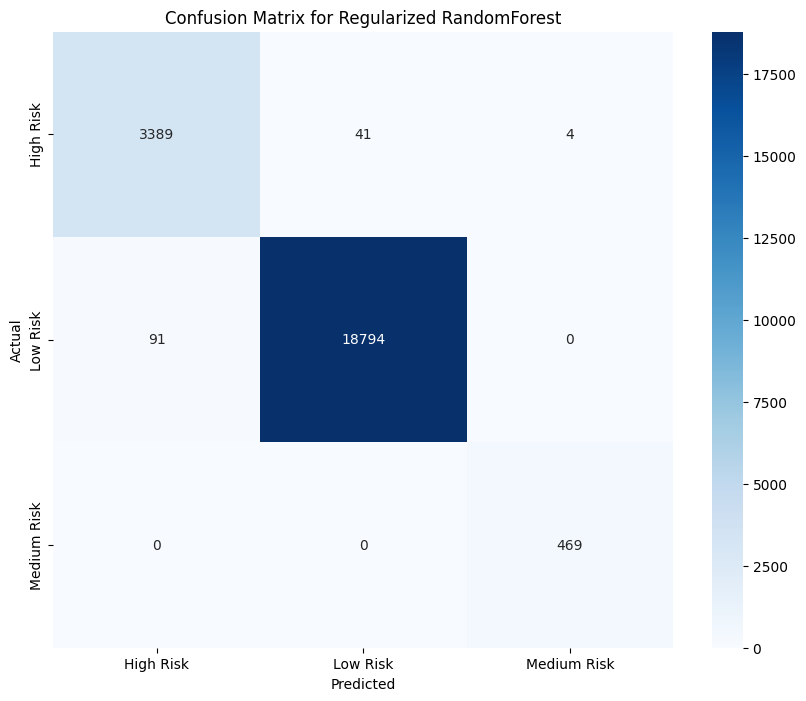

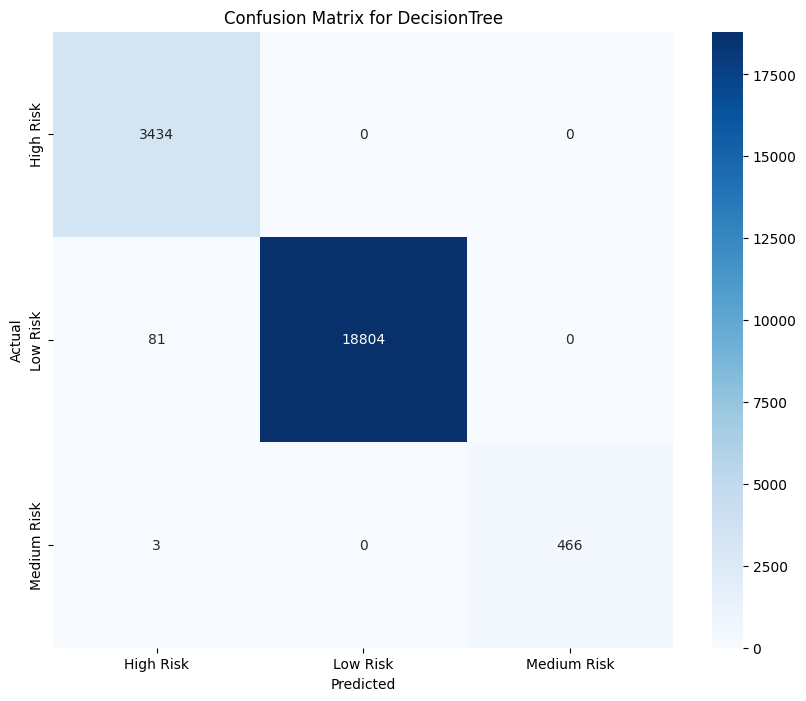

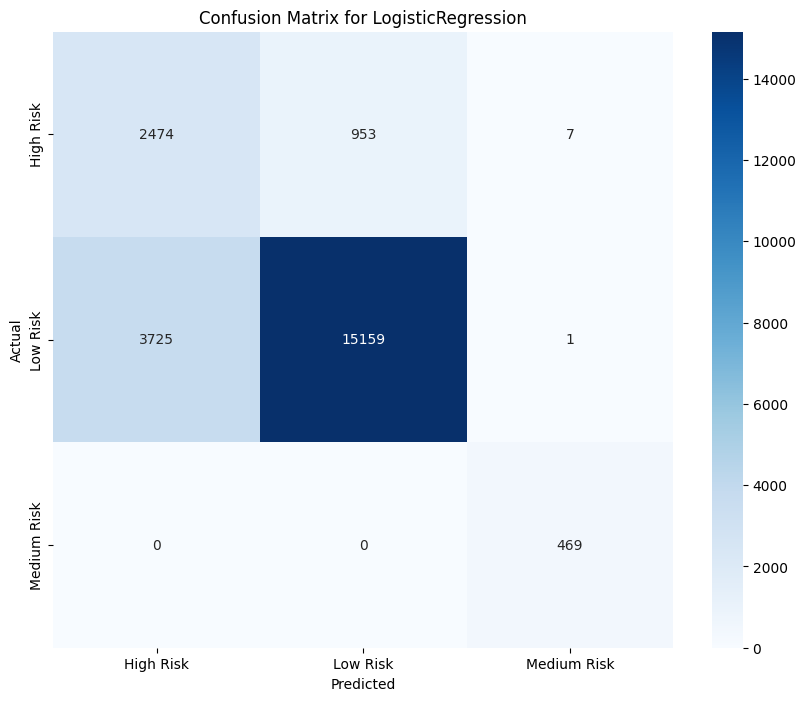

In [ ]:
# Plot confusion matrices
rf_model.fit(X_train_resampled, y_train_resampled)
y_pred_rf = rf_model.predict(X_test)

dt_model.fit(X_train_resampled, y_train_resampled)
y_pred_dt = dt_model.predict(X_test)

lr_model.fit(X_train_resampled, y_train_resampled)
y_pred_lr = lr_model.predict(X_test)

# Plot confusion matrices
plot_confusion_matrix(y_test, y_pred_rf, "RandomForest")
plot_confusion_matrix(y_test, y_pred_dt, "DecisionTree")
plot_confusion_matrix(y_test, y_pred_lr, "LogisticRegression")

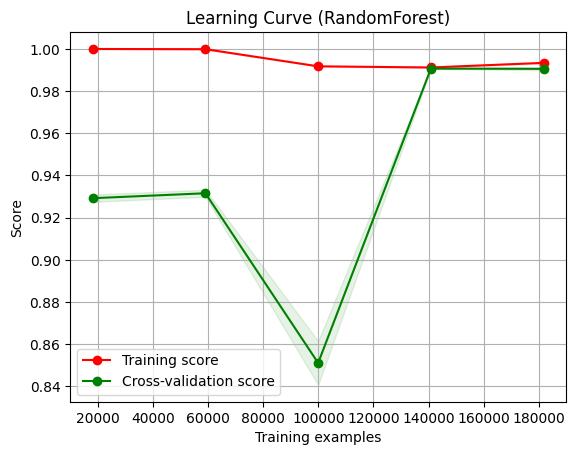

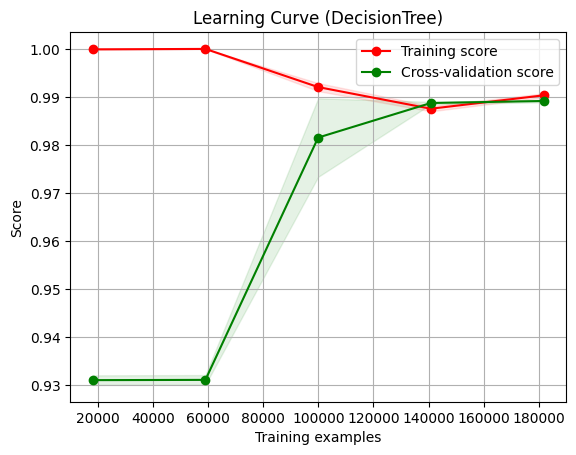

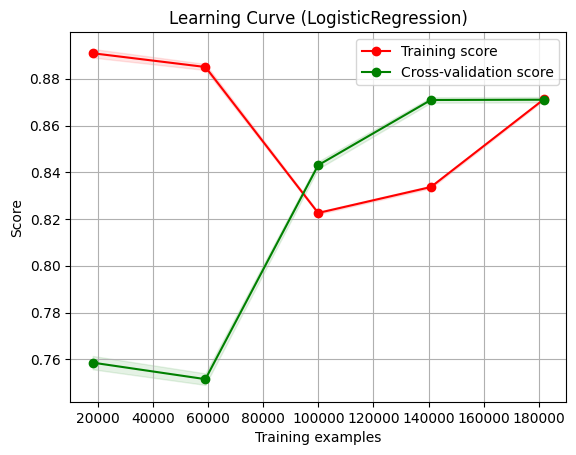

In [ ]:
# Learning Curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

plot_learning_curve(rf_model, "Learning Curve (RandomForest)", X_train_resampled, y_train_resampled, cv=kf)
plt.show()

plot_learning_curve(dt_model, "Learning Curve (DecisionTree)", X_train_resampled, y_train_resampled, cv=kf)
plt.show()

plot_learning_curve(lr_model, "Learning Curve (LogisticRegression)", X_train_resampled, y_train_resampled, cv=kf)
plt.show()